In [1]:
import csv, os, re, shutil,json, sys
import pandas as pd 
TCP = '/Users/amycweng/DH/TCP'
sys.path.append('../')

def findTextTCP(id):
    if re.match('B1|B4',id[0:2]):
        path = f'{TCP}/P2{id[0:2]}/{id}.P4.xml'
    else: 
        if f'{id}.P4.xml' in os.listdir(f'{TCP}/P1{id[0:2]}'):
            path = f'{TCP}/P1{id[0:2]}/{id}.P4.xml'
        elif f'{id}.P4.xml' in os.listdir(f'{TCP}/P2{id[0:2]}'): 
            path = f'{TCP}/P2{id[0:2]}/{id}.P4.xml'
    return path 

Find texts that contain sermons (DIV tag with attribute "TYPE"='sermon')

In [ ]:
from bs4 import BeautifulSoup, SoupStrainer
def is_sermon(filepath):
    # read the input XML file 
    with open(filepath,'r') as file: 
        data = file.read()
    # use soupstrainer to only parse the main body
    tag = SoupStrainer("DIV1")
    soup = BeautifulSoup(data,features="xml",parse_only=tag)
    sermons = soup.findAll(attrs={"TYPE": "sermon"})
    if len(sermons) > 0:      
        return True
    return False

In [ ]:
metadataFolder = '/Users/amycweng/DH/ECBC-Data-2022/TCP metadata'
sermons = []
for csvFile in os.listdir(metadataFolder):
    data = pd.read_csv(os.path.join(metadataFolder,csvFile))
    for idx,tcpID in enumerate(data['id']):
        if tcpID == "id": continue
        filepath = findTextTCP(tcpID)
        if is_sermon(filepath): 
            subject_headings = data['keywords'][idx].replace(" -- ","; ").replace("  "," ")
            sermons.append( {"id": tcpID, 
                            "estc":data['estc'][idx],
                            "stc":data['stc'][idx],
                            "title": data['title'][idx],
                            "authors": "; ".join(set(data['author'][idx].split("; "))),
                            "publisher": data['publisher'][idx],
                            "pubplace":data['pubplace'][idx],
                            "subject_headings":subject_headings,
                            "date":data['date'][idx]
                            }
            )
    print(csvFile)

P1B0.csv
P1A9.csv
P1A8.csv
P2B2.csv
P2B3.csv
P2B1.csv
P2B0.csv
P2B4.csv
P2A8.csv
P2A9.csv
P2A7.csv
P2A6.csv
P2A4.csv
P2A5.csv
P2A1.csv
P2A0.csv
P2A2.csv
P2A3.csv
P1A6.csv
P1A7.csv
P1A5.csv
P1A4.csv
P1A0.csv
P1A1.csv
P1A3.csv
P1A2.csv


In [ ]:
# store relevant metadata in a CSV file 
with open("../assets/sermons.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=sermons[0].keys())
    writer.writeheader()
    writer.writerows(sermons)

print(f"{len(sermons)} TCP XML files contain sermons.") 

4239 TCP XML files contain sermons.


In [9]:
# get catechisms and the Bible, as well as concordances 
import os 
import pandas as pd 
metadataFolder = '/Users/amycweng/DH/ECBC-Data-2022/TCP metadata'
texts = []
sermons_metadata = pd.read_csv("../assets/sermons.csv")
sermons = sermons_metadata["id"]
for csvFile in os.listdir(metadataFolder):
    data = pd.read_csv(os.path.join(metadataFolder,csvFile))
    for idx,tcpID in enumerate(data['id']):
        title = data['title'][idx]
        subject_headings = data['keywords'][idx].replace(" -- ","; ").replace("  "," ")
        if "Catechism" in subject_headings or re.search(r"The Holy Bible|Index Biblicus|Annotations upon the Holy Bible",title): 
            texts.append( {"id": tcpID, 
                                        "estc":data['estc'][idx],
                                        "stc":data['stc'][idx],
                                        "title": data['title'][idx],
                                        "authors": "; ".join(set(data['author'][idx].split("; "))),
                                        "publisher": data['publisher'][idx],
                                        "pubplace":data['pubplace'][idx],
                                        "subject_headings":subject_headings,
                                        "date":data['date'][idx]
                                        }
                        )
print(len(texts))
for t in texts: 
    t = t["id"]
    path = findTextTCP(t)
    shutil.copy(path,'/Users/amycweng/DH/bibleTCP')

377


In [10]:
# store relevant metadata in a CSV file 
with open("../assets/bible_and_catechisms.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=texts[0].keys())
    writer.writeheader()
    writer.writerows(texts)

Copy all the TCP XML files of the texts to a separate folder for easy browsing and extract plain text with proper delimiters  

In [2]:
sermons_metadata = pd.read_csv("../assets/sermons.csv")
sermons = sermons_metadata["id"]

In [ ]:
for s in sermons: 
    path = findTextTCP(s)
    shutil.copy(path,'/Users/amycweng/DH/sermonsTCP')

In [5]:
from bs4 import BeautifulSoup, SoupStrainer
sermon_counts = {} # tcpID to a count 
def extract(tcpID, filepath):
    # read the input XML file 
    with open(filepath,'r') as file: 
        data = file.read()
    # use soupstrainer to only parse the main body
    tag = SoupStrainer("DIV1")
    soup = BeautifulSoup(data,features="xml",parse_only=tag)
    sermons = soup.findAll(attrs={"TYPE": "sermon"})
    sermon_text = []
    # need to place delimiters between each sermon, marginal note, and page
    p_idx = 0 
    for idx, sermon in enumerate(sermons):
        n_idx = 0 # note's relative position within sermon
        for t in sermon.find_all(['PB']):
            # page numbers 
            if t.name == "PB" and "N" in t.attrs: 
                page = t["N"]
                t.string = f' PAGE{page} '
            else: 
                page = t["REF"]
                t.string = f' PAGEIMAGE{page}'

        for t in sermon.find_all(['P']):
            # show display characters for GAP elements (illegible characters, non-Latin alphabet) 
            for gap in t.find_all("GAP"):
                if gap["DESC"] == "foreign": 
                    gap.string = " NONLATINALPHABET " # 〈 in non-Latin alphabet 〉
                elif "DISP" in gap.attrs: 
                    disp = gap["DISP"]
                    disp = re.sub("•","^",disp) # illegible letters 
                    disp = re.sub("◊","*",disp) # illegible words 
                    gap.string = disp
            for italics in t.find_all("HI"):
                italics.string = f" STARTITALICS {italics.text} ENDITALICS "
            for item in t.find_all(["NOTE"]):
                if item.name == "NOTE":
                    # add note delimiters 
                    item.string = f" STARTNOTE{n_idx} {item.text} ENDNOTE{n_idx} "
                    n_idx += 1 
            t.string = f" STARTPARAGRAPH{p_idx} {t.text} "
            p_idx += 1 
        text = re.sub(r"[^\x00-\x7F]","",str(sermon.text))
        text = re.sub(r"[\{\}\[\]]","",text)
        text = f"{f' SERMON{idx}'} {text}"
        text = re.sub(r"\s+"," ",text)
        sermon_text.append(text)
    with open(f"../assets/plain/{tcpID}.txt","w+") as file:
        file.writelines(" ".join(sermon_text)) # write as one long string          
    return len(sermons)

In [6]:
sermon_counts = {} # tcpID to a count of its sections labeled as sermons 
for tcpID in sermons: 
    path = findTextTCP(tcpID)
    sermon_counts[tcpID] = extract(tcpID, path)
    if len(sermon_counts) % 1000 == 0: print(f"Processed {len(sermon_counts)}")

Processed 1000
Processed 2000
Processed 3000
Processed 4000


In [7]:
with open("../assets/sermon_counts.csv","w+") as outfile:
    json.dump(sermon_counts, outfile)

In [8]:
import matplotlib.pyplot as plt 
import numpy as np 
def visualize(x,y,title,xlabel,ylabel,color):
    plt.figure(figsize = (15, 10))
    plt.bar(x,y,color=color)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(np.arange(min(x), max(x)+1, 10.0), fontsize=12)
    plt.ylabel(ylabel, fontsize=15)
    plt.yticks(fontsize=10)
    plt.show()

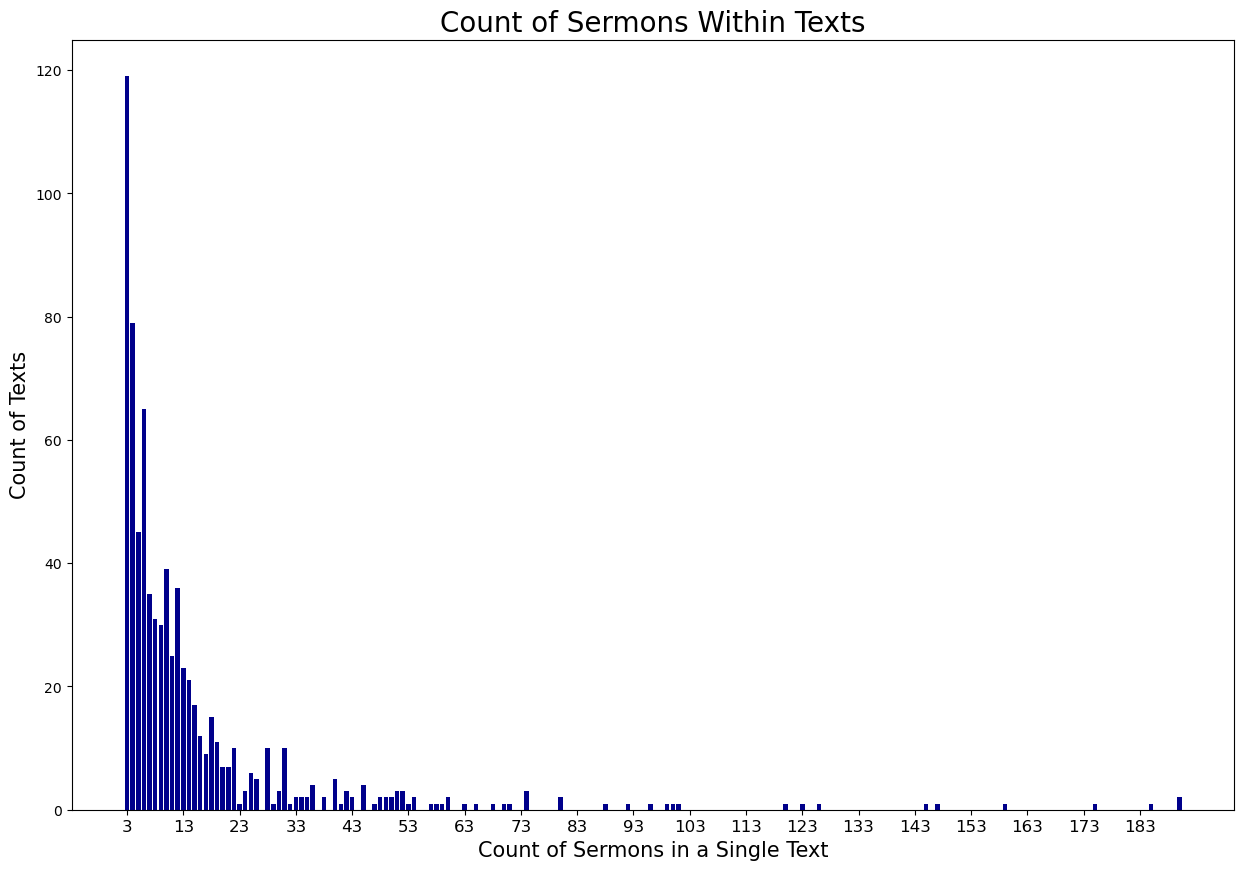

In [9]:
counts = {}
for s, count in sermon_counts.items(): 
    # if count < 3: continue
    if count not in counts: counts[count] = 0
    counts[count] += 1 
sorted_counts = {k:v for k,v in sorted(counts.items(),key=lambda k:k[1],reverse=True) if k > 2}
visualize(sorted_counts.keys(), sorted_counts.values(), 'Count of Sermons Within Texts','Count of Sermons in a Single Text','Count of Texts','darkblue')


In [10]:
print(sum(sermon_counts.values()))

15248


In [11]:
subjects = sermons_metadata["subject_headings"]
all_subjects = []
for s in subjects: 
    all_subjects.extend([_.strip('.') for _ in s.split("; ")])
from collections import Counter
print(Counter(all_subjects).most_common(n=20))


[('17th century', 3286), ('Sermons, English', 3246), ('Sermons', 3016), ('Bible', 1871), ('Early works to 1800', 1741), ('N.T', 935), ('O.T', 916), ('Funeral sermons', 461), ('Church of England', 322), ('Great Britain', 205), ('Fast-day sermons', 198), ('16th century', 195), ('History', 188), ('England', 158), ('Controversial literature', 104), ('Christian life', 99), ('Religious aspects', 78), ('Charles', 73), ('Commentaries', 63), ('Catholic Church', 63)]
